In [1]:
import warnings
warnings.filterwarnings('ignore')


import anndata as ad
import squidpy as sq
import scanpy as sc

import numpy as np
import pandas as pd
import os

import re
import json

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from cycler import cycler

In [2]:
# --------------------------------------------------------------------------------
# File I/O Setup
# --------------------------------------------------------------------------------

# OS X Laptop
#FILEPATHBASE = '/Users/mmd47/Library/CloudStorage/GoogleDrive-mmd47@yale.edu/My Drive/DiStasio Lab/DiStasio Lab Share/'

# Fedora Desktop
# conda activate cellcharter-env
FILEPATHBASE = '/home/mdistasio/YaleGoogleDrive/DiStasio Lab/DiStasio Lab Share/'


# --------------------------------------------------------------------------------

SAVEDATA = True
SAVEFIGS = True
if SAVEFIGS:
    IMGDIR = os.path.join(FILEPATHBASE,'02 Analysis', 'annData_ManualAnnotate', 'img', 'tmp')



In [3]:
# --------------------------------------------------------------------------------
# Load datasets (generated by IntegrateHarmony.py)
# --------------------------------------------------------------------------------
filename = os.path.join(FILEPATHBASE,'02 Analysis', 'annData_ManualAnnotate', 'calc', 'retinas_all_integrated_harmony_unfiltered.h5ad')
print("Loading Data from: " + filename + ' ...')
retinas_all = ad.read_h5ad(filename)

# Load the single nucleus RNA Seq data
filename_sn = os.path.join(FILEPATHBASE,'02 Analysis', 'annData_ManualAnnotate', 'calc', 'retina_sn_combined.h5ad')
print('Loading snRNAseq data from' + filename_sn + ' ...')
retinas_sn = ad.read_h5ad(filename_sn)
print('Done')

SampleKey = retinas_all.uns["SampleKey"]
Samples = list(retinas_all.obs['dataset'].cat.categories)

Loading Data from: /home/mdistasio/YaleGoogleDrive/DiStasio Lab/DiStasio Lab Share/02 Analysis/annData_ManualAnnotate/calc/retinas_all_integrated_harmony_unfiltered.h5ad ...
Loading snRNAseq data from/home/mdistasio/YaleGoogleDrive/DiStasio Lab/DiStasio Lab Share/02 Analysis/annData_ManualAnnotate/calc/retina_sn_combined.h5ad ...
Done


Global seed set to 0
CUDA backend failed to initialize: Unable to use CUDA because of the following issues with CUDA components:
Outdated cuDNN installation found.
Version JAX was built against: 8906
Minimum supported: 8900
Installed version: 8302
The local installation version must be no lower than 8900. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Fitting an scVI model to the spatial data...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 74/127:  58%|█████████████████████████████████████████▎                             | 74/127 [08:54<06:22,  7.23s/it, loss=382, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 428.074. Signaling Trainer to stop.


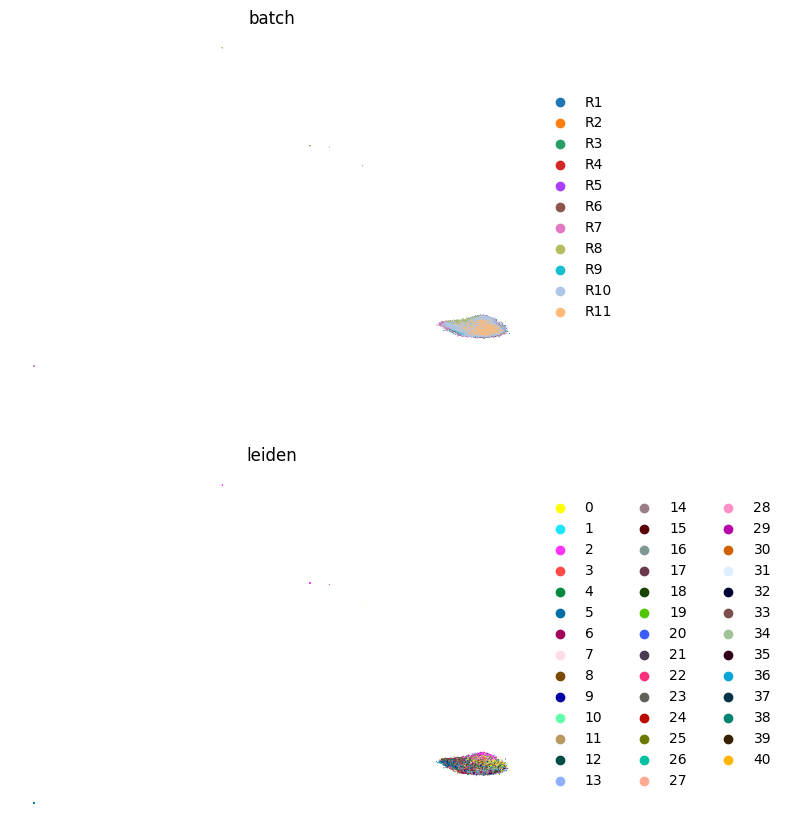

Done fitting an scVI model to the spatial data. Added retinas_all.layers['counts_scvi']
Fitting GIMVI model to the single cell and spatial data...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|█████████████████████████████████████████████████████████████████████| 200/200 [37:21<00:00, 11.18s/it, loss=105, v_num=1]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|█████████████████████████████████████████████████████████████████████| 200/200 [37:21<00:00, 11.21s/it, loss=105, v_num=1]
Saved /home/mdistasio/YaleGoogleDrive/DiStasio Lab/DiStasio Lab Share/02 Analysis/annData_ManualAnnotate/calc/retinas_all_unfiltered_snRNAseq_imputed_GIMVI.h5ad


In [4]:
# --------------------------------------------------------------------------------
# Imputation from snRNAseq data
# --------------------------------------------------------------------------------

import scvi
from scvi.external import GIMVI
from scipy import sparse

# Fit an scVI model to the spatial data
print('Fitting an scVI model to the spatial data...')
scvi.model.SCVI.setup_anndata(retinas_all, layer="counts", batch_key="dataset")
model = scvi.model.SCVI(retinas_all, n_layers=2, n_latent=30, gene_likelihood="nb")
model.train(early_stopping=True, enable_progress_bar=True)

SCVI_LATENT_KEY = "X_scVI"
retinas_all.obsm[SCVI_LATENT_KEY] = model.get_latent_representation().astype(np.float32)

SCVI_NEIGHBORS_KEY = "neighbors_scVI"
sc.pp.neighbors(retinas_all, use_rep=SCVI_LATENT_KEY, key_added=SCVI_NEIGHBORS_KEY)
sc.tl.leiden(retinas_all, key_added="leiden_scVI", neighbors_key=SCVI_NEIGHBORS_KEY)

SCVI_MDE_KEY = "X_scVI_MDE"
retinas_all.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(retinas_all.obsm[SCVI_LATENT_KEY])

sc.pl.embedding(
    retinas_all,
    basis=SCVI_MDE_KEY,
    color=["batch", "leiden"],
    frameon=False,
    ncols=1,
)
retinas_all.layers['counts_scvi'] = sparse.csr_matrix(model.posterior_predictive_sample())
print('Done fitting an scVI model to the spatial data. Added retinas_all.layers[\'counts_scvi\']')



print('Fitting GIMVI model to the single cell and spatial data...')
# Copy the data for the imputation
st_adata = retinas_all.copy()
sc_adata = retinas_sn.copy()

# filter genes to be the same on the spatial data
intersect = np.intersect1d(sc_adata.var_names, st_adata.var_names)
st_adata = st_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()


# setup_anndata for spatial and sequencing data
GIMVI.setup_anndata(st_adata, layer="counts", batch_key="dataset")
GIMVI.setup_anndata(sc_adata, layer="counts", labels_key="CellType")

model = GIMVI(sc_adata, st_adata)
model.train(max_epochs=200, early_stopping=True, enable_progress_bar=True)

# get the latent representations for the sequencing and spatial data
_, imputed = model.get_imputed_values(normalized=True)

def transform(data):
    return np.log(1 + 100 * data)

retinas_all[:,st_adata.var_names] = transform(imputed)

if SAVEDATA:
    # Save
    filename_out = os.path.join(FILEPATHBASE,'02 Analysis', 'annData_ManualAnnotate', 'calc', 'retinas_all_unfiltered_snRNAseq_imputed_GIMVI.h5ad')
    retinas_all.write_h5ad(filename_out)
    print('Saved ' + filename_out)

    model.save(dir_path=os.path.join(FILEPATHBASE,'02 Analysis', 'annData_ManualAnnotate', 'calc','GIMVI_model'), 
                  prefix='retinas_all_unfiltered_snRNAseq_imputation',
                  overwrite=True)

In [5]:
import cellcharter as cc

# Arrange samples in space
retinas_all.obsm['X_spatial_fov'] = retinas_all.obsm['X_spatial'].copy()
y_max_p = [np.max(retinas_all[retinas_all.obs['dataset']==Samples[r]].obsm['X_spatial'][:,1]) for r in np.arange(1,len(Samples))]
y_offsets = np.append(0,np.cumsum(y_max_p))
for r in np.arange(1,len(Samples)):
    retinas_all.obsm['X_spatial_fov'][retinas_all.obs['dataset']==Samples[r],1] = retinas_all.obsm['X_spatial_fov'][retinas_all.obs['dataset']==Samples[r],1] + y_offsets[r]

#
sq.gr.spatial_neighbors(retinas_all, coord_type='generic', delaunay=True, spatial_key='X_spatial_fov')
cc.gr.remove_long_links(retinas_all)
cc.gr.aggregate_neighbors(retinas_all, n_layers=3, use_rep='X_scVI', out_key='X_cellcharter', sample_key='batch')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.96it/s]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.26it/s]
Saved: /home/mdistasio/YaleGoogleDrive/DiStasio Lab/DiStasio Lab Share/02 Analysis/annData_ManualAnnotate/img/tmp/AllSamples_GIMVI_CellCharter_21_Clusters_005.png
Saved: /home/mdistasio/YaleGoogleDrive/DiStasio Lab/DiStasio Lab Share/02 Analysis/annData_ManualAnnotate/img/tmp/AllSamples_GIMVI_CellCharter_21_Clusters_005.svg


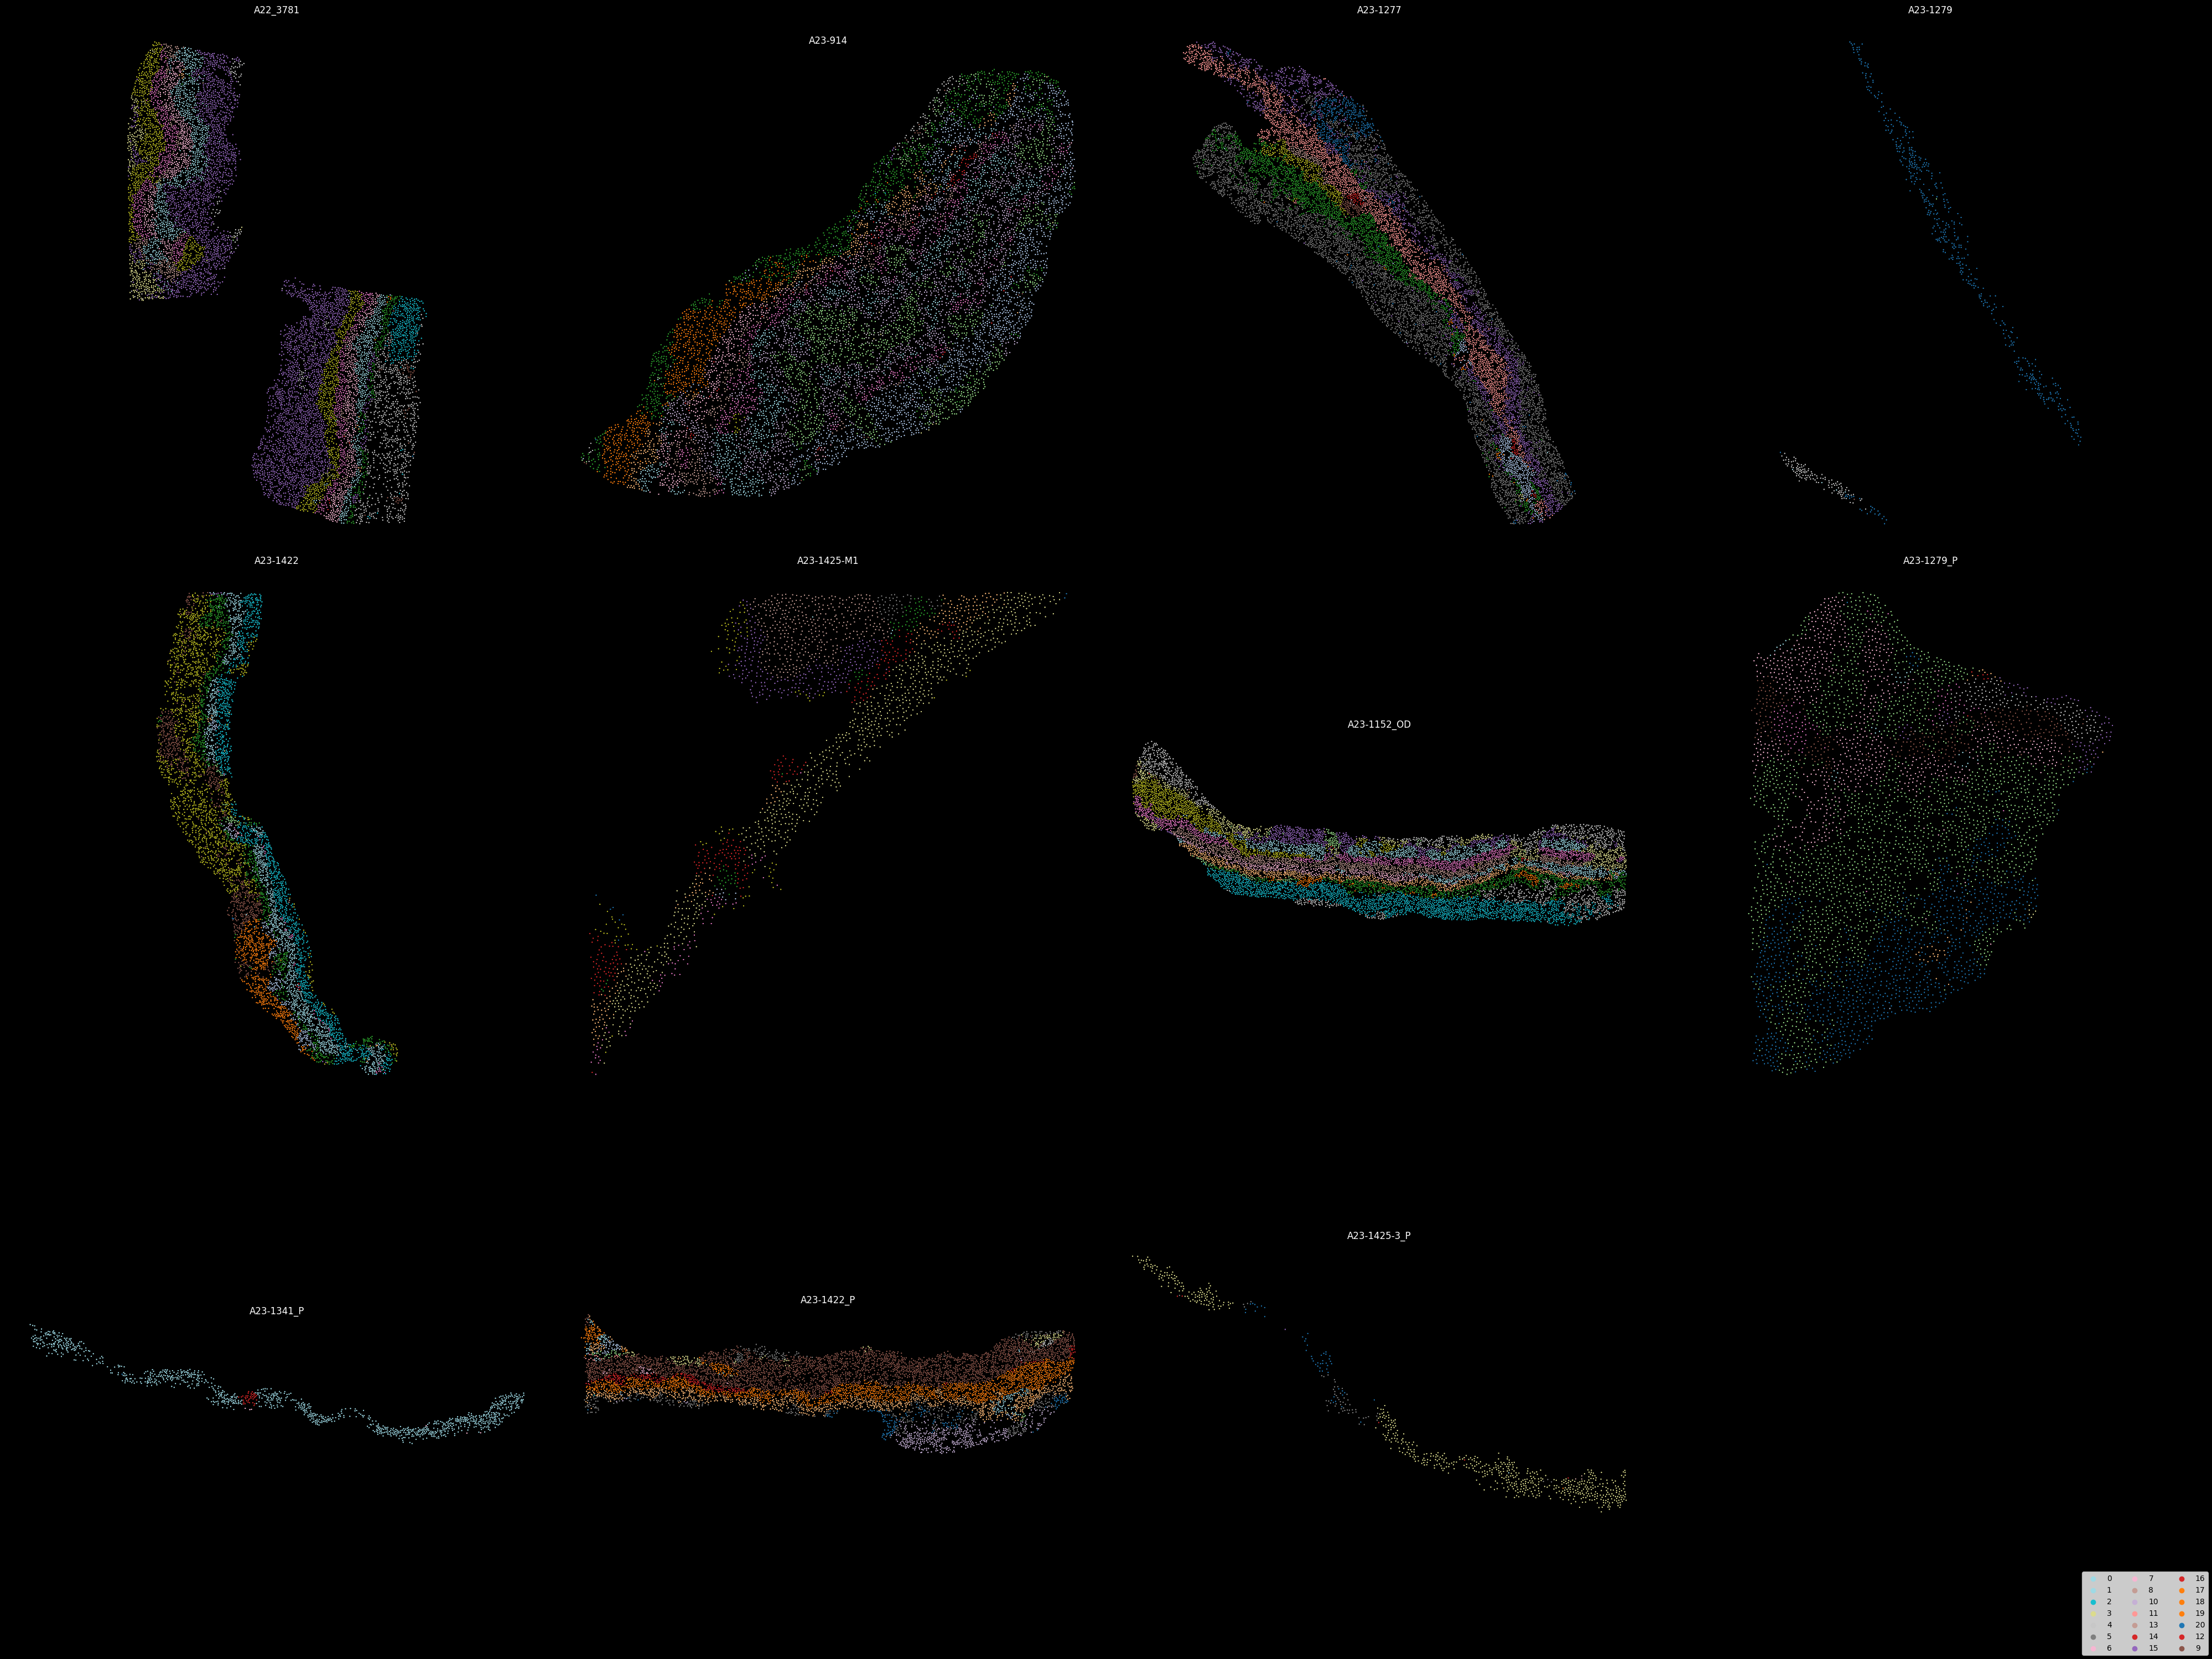

In [6]:
n_clusters = 21

gmm = cc.tl.Cluster(
    n_clusters=n_clusters, 
    random_state=12345,
    # If running on GPU
    trainer_params=dict(accelerator='gpu', devices=1)
)
gmm.fit(retinas_all, use_rep='X_cellcharter')
retinas_all.obs['spatial_cluster'] = gmm.predict(retinas_all, use_rep='X_cellcharter')

# Plotting
GroupsToAnalyze = list(np.arange(0,n_clusters))
groups = [sorted(np.unique(retinas_all.obs['spatial_cluster']), key=lambda x: int(x))[i] for i in GroupsToAnalyze]
nGroupsToPlot = len(GroupsToAnalyze)
spect = plt.cm.tab20.resampled(nGroupsToPlot)
newcolors = np.flip(spect(np.linspace(0,1,nGroupsToPlot)), axis=0)
newpalette = ListedColormap(newcolors)
color_cycler = cycler(color=newpalette.colors)



nRow = 3
nCol = int(np.ceil(len(Samples)/3))
fig, axs = plt.subplots(nRow, nCol, figsize=(40,30))
for r in np.arange(len(Samples)):
    ax = axs.reshape(-1)[r]
    ss = 1
    sq.pl.spatial_scatter(retinas_all[retinas_all.obs['dataset']==Samples[r]],
                          color='spatial_cluster',
                          size=ss,
                          shape=None,
                          groups=groups,
                          ax=ax,
                          palette=newpalette)
    ax.set_title(SampleKey[Samples[r]])

for ax in axs.reshape(-1):
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.axis('off')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    try:
        ax.get_legend().remove()
    except:
        pass

fig.tight_layout()

fig.set_facecolor('k')
for text in fig.findobj(match=lambda x: isinstance(x, plt.Text)):
    if hasattr(text, 'set_color'):
        text.set_color('white')

labels_handles = {  label: handle for ax in fig.axes for handle, label in zip(*ax.get_legend_handles_labels())    }
fig.legend( labels_handles.values(), labels_handles.keys(), loc = "lower right", ncol=3)

if SAVEFIGS:
    filename_out = os.path.join(IMGDIR, 'AllSamples_GIMVI_CellCharter_' + str(n_clusters) + '_Clusters_005.png')
    fig.savefig(filename_out, dpi=300)
    print('Saved: ' + filename_out)
    filename_out = os.path.join(IMGDIR, 'AllSamples_GIMVI_CellCharter_' + str(n_clusters) + '_Clusters_005.svg')
    fig.savefig(filename_out, dpi=300)
    print('Saved: ' + filename_out)

Saved: /home/mdistasio/YaleGoogleDrive/DiStasio Lab/DiStasio Lab Share/02 Analysis/annData_ManualAnnotate/img/tmp/AllSamples_GIMVI_CellCharter_21_Clusters_006_markermatrix.png
Saved: /home/mdistasio/YaleGoogleDrive/DiStasio Lab/DiStasio Lab Share/02 Analysis/annData_ManualAnnotate/img/tmp/AllSamples_GIMVI_CellCharter_21_Clusters_006_markermatrix.svg


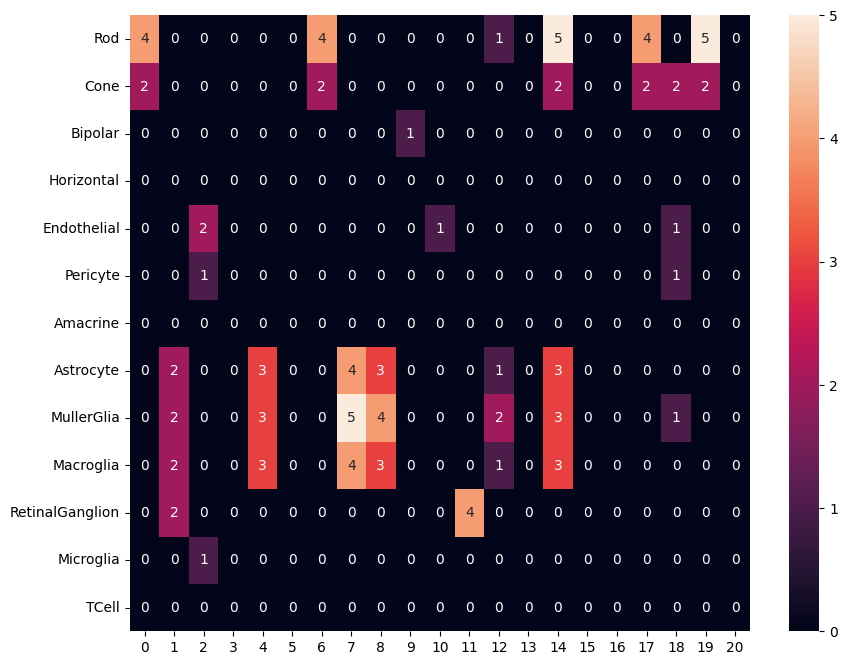

In [113]:
#### Marker genes

#sc.tl.rank_genes_groups(retinas_all, 'spatial_cluster', method='t-test')
#sc.pl.rank_genes_groups(retinas_all, n_genes=5, sharey=False)



with open(os.path.join(FILEPATHBASE,'02 Analysis/annData_ManualAnnotate/data/retinal_celltype_gates.json')) as f:
    gates = json.load(f)

sc.tl.rank_genes_groups(retinas_all, 'spatial_cluster', use_raw=True)
#sc.pl.rank_genes_groups(st_adata, n_genes=25, sharey=False)

marker_genes = {}
for item in gates:
    cell_type = item['cell']
    gene_list = [gene['gene'] for gene in item['gates']]
    marker_genes[cell_type] = gene_list
ov = sc.tl.marker_gene_overlap(retinas_all, marker_genes)

fig, ax = plt.subplots(1, 1, figsize=(10,8))
sns.heatmap(ov, ax=ax, annot=True)

if SAVEFIGS:
    filename_out = os.path.join(IMGDIR, 'AllSamples_GIMVI_CellCharter_' + str(n_clusters) + '_Clusters_006_markermatrix.png')
    fig.savefig(filename_out, dpi=300)
    print('Saved: ' + filename_out)
    filename_out = os.path.join(IMGDIR, 'AllSamples_GIMVI_CellCharter_' + str(n_clusters) + '_Clusters_006_markermatrix.svg')
    fig.savefig(filename_out, dpi=300)
    print('Saved: ' + filename_out)

Saved: /home/mdistasio/YaleGoogleDrive/DiStasio Lab/DiStasio Lab Share/02 Analysis/annData_ManualAnnotate/img/tmp/AllSamples_GIMVI_CellCharter_21_Clusters_006_typelabels.png
Saved: /home/mdistasio/YaleGoogleDrive/DiStasio Lab/DiStasio Lab Share/02 Analysis/annData_ManualAnnotate/img/tmp/AllSamples_GIMVI_CellCharter_21_Clusters_006_typelabels.svg


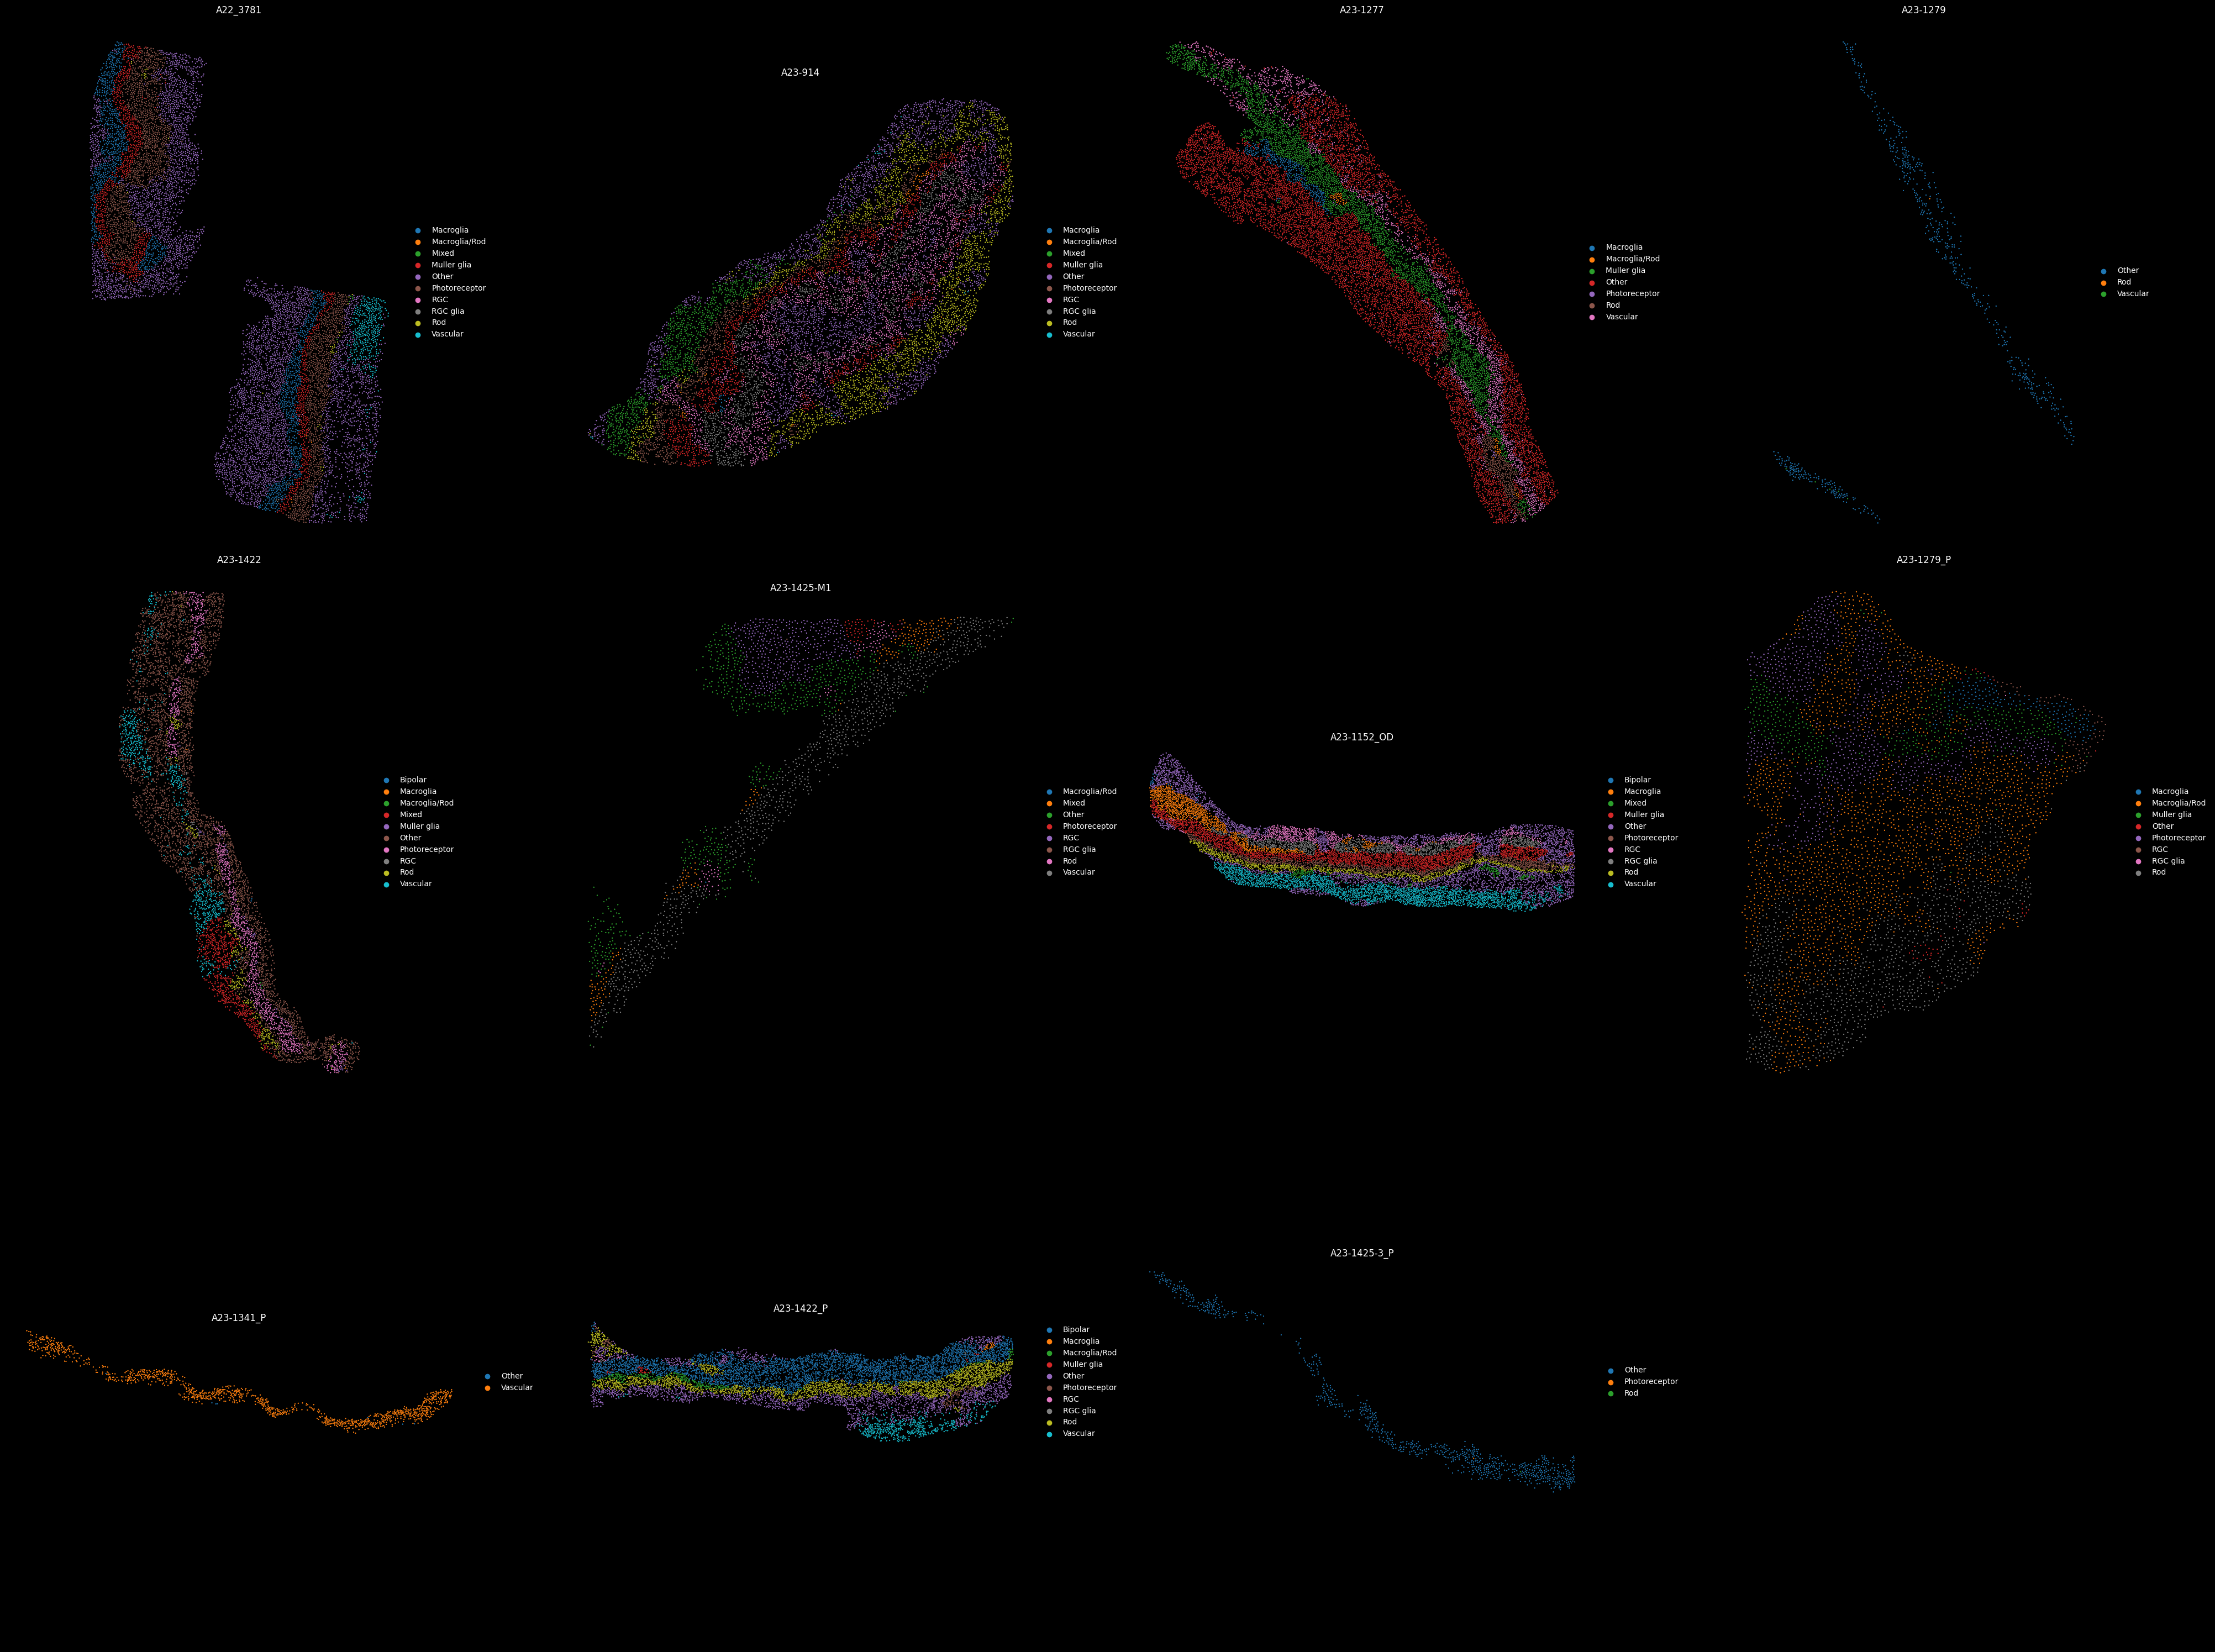

In [106]:
spatial_cluster_label_key = {0 : 'Photoreceptor',
                             1 : 'RGC glia',
                             2 : 'Vascular',
                             3 : 'Other',
                             4 : 'Macroglia',
                             5 : 'Other',
                             6 : 'Photoreceptor',
                             7 : 'Muller glia',
                             8 : 'Muller glia',
                             9 : 'Bipolar',
                             10: 'Vascular',
                             11: 'RGC',
                             12: 'Muller glia',
                             13: 'Other',
                             14: 'Macroglia/Rod',
                             15: 'Other',
                             16: 'Other',
                             17: 'Rod',
                             18: 'Mixed',
                             19: 'Rod',
                             20: 'Other'}

retinas_all.obs['spatial_cluster_label'] = retinas_all.obs['spatial_cluster'].map(spatial_cluster_label_key)


# Plotting
#groups = sorted(np.unique(retinas_all.obs['spatial_cluster_label']))
#nGroupsToPlot = len(groups)
#spect = plt.cm.tab10.resampled(nGroupsToPlot)
#newcolors = np.flip(spect(np.linspace(0,1,nGroupsToPlot)), axis=0)
#newpalette = ListedColormap(newcolors)
#color_cycler = cycler(color=newpalette.colors)


groups = np.array(sorted(np.unique(retinas_all.obs['spatial_cluster_label'])))
#groups_to_gray = ['Other', 'Mixed']
nGroupsToColor = len(groups) 
spect = plt.cm.tab10.resampled(nGroupsToColor)
newcolors = spect(np.linspace(0,0.5,nGroupsToColor))

#togray = [i for i,l in enumerate(groups) if l in groups_to_gray]
#g = groups[togray]
#groups = np.delete(groups, togray)
#groups = np.append(groups, g)
#groups = list(groups)
#for i in togray:
#    newcolors[i,:] =  [0.5,0.5,0.5,1]
newpalette = ListedColormap(newcolors)


color_cycler = cycler(color=newpalette.colors)


 


In [114]:
retinas_all

AnnData object with n_obs × n_vars = 62961 × 38489
    obs: 'Retina_2', 'OpticNerve', 'Retina_1', 'Retina', 'dataset', 'batch', 'leiden', '_scvi_batch', '_scvi_labels', 'leiden_scVI', 'spatial_cluster', 'spatial_cluster_label'
    uns: 'Anatomic_Location', 'SampleKey', 'leiden', 'leiden_sizes', 'neighbors', 'paga', 'pca', 'spatial', 'umap', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors_scVI', 'leiden_scVI', 'batch_colors', 'leiden_colors', 'spatial_neighbors', '_cellcharter', 'rank_genes_groups'
    obsm: 'X_pca', 'X_pca_harmony', 'X_spatial', 'X_umap', 'spatial', 'X_scVI', 'X_scVI_MDE', 'X_spatial_fov', 'X_cellcharter'
    varm: 'PCs'
    layers: 'counts', 'counts_scvi'
    obsp: 'connectivities', 'distances', 'neighbors_scVI_distances', 'neighbors_scVI_connectivities', 'spatial_connectivities', 'spatial_distances'

In [90]:
groups = np.array(sorted(np.unique(retinas_all.obs['spatial_cluster_label'])))
groups_to_gray = ['Other', 'Mixed']
nGroupsToColor = len(groups) - len(groups_to_gray)
spect = plt.cm.tab10.resampled(nGroupsToColor)
newcolors = spect(np.linspace(0,1,nGroupsToColor))
togray = [i for i,l in enumerate(groups) if l in groups_to_gray]
g = groups[togray]
groups = np.delete(groups, togray)
groups = np.append(groups, g)
groups = list(groups)
for i in np.arange(len(togray)):
    newcolors = np.vstack([newcolors, [0.5,0.5,0.5,1]])
newpalette = ListedColormap(newcolors)

newpalette_ = dict(zip(groups, newcolors))



{'Bipolar': array([0.12156863, 0.46666667, 0.70588235, 1.        ]),
 'Macroglia': array([1.        , 0.49803922, 0.05490196, 1.        ]),
 'Macroglia/Rod': array([0.17254902, 0.62745098, 0.17254902, 1.        ]),
 'Muller glia': array([0.83921569, 0.15294118, 0.15686275, 1.        ]),
 'Photoreceptor': array([0.54901961, 0.3372549 , 0.29411765, 1.        ]),
 'RGC': array([0.89019608, 0.46666667, 0.76078431, 1.        ]),
 'RGC glia': array([0.49803922, 0.49803922, 0.49803922, 1.        ]),
 'Rod': array([0.7372549 , 0.74117647, 0.13333333, 1.        ]),
 'Vascular': array([0.09019608, 0.74509804, 0.81176471, 1.        ]),
 'Mixed': array([0.5, 0.5, 0.5, 1. ]),
 'Other': array([0.5, 0.5, 0.5, 1. ])}